In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.io as isoio
import isolearn.keras as isol

from genesis.visualization import *
from genesis.generator import *
from genesis.predictor import *
from genesis.optimizer import *
import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from scipy.stats import pearsonr

import seaborn as sns

from matplotlib import colors

import editdistance

def subselect_list(li, ixs) :
    return [
        li[ixs[k]] for k in range(len(ixs))
    ]

class IdentityEncoder(iso.SequenceEncoder) :
    
    def __init__(self, seq_len, channel_map) :
        super(IdentityEncoder, self).__init__('identity', (seq_len, len(channel_map)))
        
        self.seq_len = seq_len
        self.n_channels = len(channel_map)
        self.encode_map = channel_map
        self.decode_map = {
            nt: ix for ix, nt in self.encode_map.items()
        }
    
    def encode(self, seq) :
        encoding = np.zeros((self.seq_len, self.n_channels))
        
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.

        return encoding
    
    def encode_inplace(self, seq, encoding) :
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.
    
    def encode_inplace_sparse(self, seq, encoding_mat, row_index) :
        raise NotImplementError()
    
    def decode(self, encoding) :
        seq = ''
    
        for pos in range(0, encoding.shape[0]) :
            argmax_nt = np.argmax(encoding[pos, :])
            max_nt = np.max(encoding[pos, :])
            seq += self.decode_map[argmax_nt]

        return seq
    
    def decode_sparse(self, encoding_mat, row_index) :
        raise NotImplementError()

#Plot joint histograms
def plot_joint_histo(measurements, labels, x_label, y_label, colors=None, n_bins=50, figsize=(6, 4), legend_outside=False, save_fig=False, fig_name="default_1", fig_dpi=150, min_val=None, max_val=None, max_y_val=None) :
    
    min_hist_val = np.min(measurements[0])
    max_hist_val = np.max(measurements[0])
    for i in range(1, len(measurements)) :
        min_hist_val = min(min_hist_val, np.min(measurements[i]))
        max_hist_val = max(max_hist_val, np.max(measurements[i]))
    
    if min_val is not None :
        min_hist_val = min_val
    if max_val is not None :
        max_hist_val = max_val

    hists = []
    bin_edges = []
    means = []
    for i in range(len(measurements)) :
        hist, b_edges = np.histogram(measurements[i], range=(min_hist_val, max_hist_val), bins=n_bins, density=True)
        
        hists.append(hist)
        bin_edges.append(b_edges)
        means.append(np.mean(measurements[i]))
    
    bin_width = bin_edges[0][1] - bin_edges[0][0]


    f = plt.figure(figsize=figsize)

    for i in range(len(measurements)) :
        if colors is not None :
            plt.bar(bin_edges[i][1:] - bin_width/2., hists[i], width=bin_width, linewidth=2, edgecolor='black', color=colors[i], label=labels[i])
        else :
            plt.bar(bin_edges[i][1:] - bin_width/2., hists[i], width=bin_width, linewidth=2, edgecolor='black', label=labels[i])
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    plt.xlim(min_hist_val, max_hist_val)
    if max_y_val is not None :
        plt.ylim(0, max_y_val)

    plt.xlabel(x_label, fontsize=14)
    plt.ylabel(y_label, fontsize=14)

    if colors is not None :
        for i in range(len(measurements)) :
            plt.axvline(x=means[i], linewidth=2, color=colors[i], linestyle="--")

    if not legend_outside :
        plt.legend(fontsize=14, loc='upper left')
    else :
        plt.legend(fontsize=14, bbox_to_anchor=(1.04,1), loc="upper left")
    
    plt.tight_layout()
    
    if save_fig :
        plt.savefig(fig_name + ".eps")
        plt.savefig(fig_name + ".svg")
        plt.savefig(fig_name + ".png", dpi=fig_dpi, transparent=True)
    
    plt.show()

#Plot join histograms
def plot_joint_cmp(measurements, labels, y_label, plot_type='violin', colors=None, figsize=(6, 4), legend_outside=False, save_fig=False, fig_name="default_1", fig_dpi=150, min_y_val=None, max_y_val=None, violin_bw=None, violin_cut=None) :
    
    f = plt.figure(figsize=figsize)

    sns_g = None
    if colors is not None :
        if plot_type == 'violin' :
            if violin_bw is None :
                if violin_cut is None :
                    sns_g = sns.violinplot(data=measurements, palette=colors, scale='width')
                else :
                    sns_g = sns.violinplot(data=measurements, palette=colors, scale='width', cut=violin_cut)
            else :
                if violin_cut is None :
                    sns_g = sns.violinplot(data=measurements, palette=colors, scale='width', bw=violin_bw)
                else :
                    sns_g = sns.violinplot(data=measurements, palette=colors, scale='width', bw=violin_bw, cut=violin_cut)
        elif plot_type == 'strip' :
            sns_g = sns.stripplot(data=measurements, palette=colors, alpha=0.1, jitter=0.3, linewidth=2, edgecolor='black') #, x=labels
            for i in range(len(measurements)) :
                plt.plot(x=[i, i+1], y=[np.median(measurements[i]), np.median(measurements[i])], linewidth=2, color=colors[i], linestyle="--")
        elif plot_type == 'bar' :
            for i in range(len(measurements)) :
                plt.bar([i], [np.percentile(measurements[i], 100)], width=0.4, color=colors[i], label=str(i) + ") " + labels[i], linewidth=2, edgecolor='black')
                plt.bar([i+0.2], [np.percentile(measurements[i], 95)], width=0.4, color=colors[i], linewidth=2, edgecolor='black')
                plt.bar([i+0.4], [np.percentile(measurements[i], 80)], width=0.4, color=colors[i], linewidth=2, edgecolor='black')
                plt.bar([i+0.6], [np.percentile(measurements[i], 50)], width=0.4, color=colors[i], linewidth=2, edgecolor='black')
    else :
        if plot_type == 'violin' :
            if violin_bw is None :
                if violin_cut is None :
                    sns_g = sns.violinplot(data=measurements, scale='width')
                else :
                    sns_g = sns.violinplot(data=measurements, scale='width', cut=violin_cut)
            else :
                if violin_cut is None :
                    sns_g = sns.violinplot(data=measurements, scale='width', bw=violin_bw)
                else :
                    sns_g = sns.violinplot(data=measurements, scale='width', bw=violin_bw, cut=violin_cut)
        elif plot_type == 'strip' :
            sns_g = sns.stripplot(data=measurements, alpha=0.1, jitter=0.3, linewidth=2, edgecolor='black') #, x=labels
        elif plot_type == 'bar' :
            for i in range(len(measurements)) :
                plt.bar([i], [np.percentile(measurements[i], 100)], width=0.25, label=str(i) + ") " + labels[i], linewidth=2, edgecolor='black')
                plt.bar([i+0.125], [np.percentile(measurements[i], 95)], width=0.25, linewidth=2, edgecolor='black')
                plt.bar([i+0.25], [np.percentile(measurements[i], 80)], width=0.25, linewidth=2, edgecolor='black')
                plt.bar([i+0.375], [np.percentile(measurements[i], 50)], width=0.25, linewidth=2, edgecolor='black')
    
    plt.xticks(np.arange(len(labels)), fontsize=14)
    plt.yticks(fontsize=14)
    
    #plt.xlim(min_hist_val, max_hist_val)
    if min_y_val is not None and max_y_val is not None :
        plt.ylim(min_y_val, max_y_val)

    plt.ylabel(y_label, fontsize=14)
    
    if plot_type not in ['violin', 'strip'] :
        if not legend_outside :
            plt.legend(fontsize=14, loc='upper left')
        else :
            plt.legend(fontsize=14, bbox_to_anchor=(1.04,1), loc="upper left")
    else :
        if not legend_outside :
            f.get_axes()[0].legend(fontsize=14, loc="upper left", labels=[str(label_i) + ") " + label for label_i, label in enumerate(labels)])
        else :
            f.get_axes()[0].legend(fontsize=14, bbox_to_anchor=(1.04,1), loc="upper left", labels=[str(label_i) + ") " + label for label_i, label in enumerate(labels)])
    
    plt.tight_layout()
    
    if save_fig :
        plt.savefig(fig_name + ".eps")
        plt.savefig(fig_name + ".svg")
        plt.savefig(fig_name + ".png", dpi=fig_dpi, transparent=True)
    
    plt.show()

#Load generated data from models to be evaluated

def load_sequences(file_path, split_on_tab=True, seq_template=None, max_n_sequences=1e6, select_best_fitness=False, predictor=None, batch_size=32) :
    seqs = []
    
    with open(file_path, "rt") as f :
        for l in f.readlines() :
            l_strip = l.strip()
            seq = l_strip
            if split_on_tab :
                seq = l_strip.split("\t")[0]
            
            if seq_template is not None :
                seq = ''.join([
                    seq_template[j] if seq_template[j] != 'N' else seq[j]
                    for j in range(len(seq))
                ])

            seqs.append(seq)
        
    if select_best_fitness and predictor is not None :
        onehots = np.expand_dims(np.concatenate([
            np.expand_dims(acgt_encoder.encode(seq), axis=0) for seq in seqs
        ], axis=0), axis=-1)

        #Predict fitness
        score_pred = predictor.predict(x=[onehots[..., 0]], batch_size=batch_size)
        score_pred = np.ravel(score_pred[:, 5])
        
        sort_index = np.argsort(score_pred)[::-1]
        seqs = [
            seqs[sort_index[i]] for i in range(len(seqs))
        ]
    
    return seqs[:max_n_sequences]

#Metric helper functions

def compute_latent_manhattan_distance(latent_vecs) :
    shuffle_index = np.arange(latent_vecs.shape[0])
    shuffle_index = shuffle_index[::-1]#np.random.shuffle(shuffle_index)

    latent_vecs_shuffled = latent_vecs[shuffle_index]
    latent_dists = np.sum(np.abs(latent_vecs - latent_vecs_shuffled), axis=-1)

    mean_latent_distance = np.mean(latent_dists)
    
    return latent_dists, mean_latent_distance

def compute_latent_cosine_distance(latent_vecs) :
    shuffle_index = np.arange(latent_vecs.shape[0])
    shuffle_index = shuffle_index[::-1]#np.random.shuffle(shuffle_index)

    latent_vecs_shuffled = latent_vecs[shuffle_index]
    latent_cosines = np.sum(latent_vecs * latent_vecs_shuffled, axis=-1) / (np.sqrt(np.sum(latent_vecs**2, axis=-1)) * np.sqrt(np.sum(latent_vecs_shuffled**2, axis=-1)))
    latent_cosines = 1. - latent_cosines
    
    mean_latent_cosine = np.mean(latent_cosines)
    
    return latent_cosines, mean_latent_cosine

def compute_edit_distance(onehots, opt_len=100) :
    shuffle_index = np.arange(onehots.shape[0])
    shuffle_index = shuffle_index[::-1]#np.random.shuffle(shuffle_index)
    
    seqs = [acgt_encoder.decode(onehots[i, :, :, 0]) for i in range(onehots.shape[0])]
    seqs_shuffled = [seqs[shuffle_index[i]] for i in range(onehots.shape[0])]
    edit_distances = np.ravel([float(editdistance.eval(seq_1, seq_2)) for seq_1, seq_2 in zip(seqs, seqs_shuffled)])
    edit_distances /= opt_len
    
    mean_edit_distance = np.mean(edit_distances)
    
    return edit_distances, mean_edit_distance

#Evaluate metrics for each model

def compute_metrics(seqs, n_seqs_to_test=960, batch_size=64, opt_len=90) :
    
    n_seqs_to_test = min(len(seqs), n_seqs_to_test)
    
    onehots = np.expand_dims(np.concatenate([
        np.expand_dims(acgt_encoder.encode(seq), axis=0) for seq in seqs
    ], axis=0), axis=-1)

    #Predict fitness
    score_pred, dense_pred = saved_predictor_w_dense.predict(x=[onehots[:n_seqs_to_test, :, :, 0]], batch_size=batch_size)
    score_pred = np.ravel(score_pred[:, 5])
    
    #Compare pair-wise latent distances
    dense_dists, _ = compute_latent_manhattan_distance(dense_pred)

    #Compare pair-wise latent cosine similarities
    dense_cosines, _ = compute_latent_cosine_distance(dense_pred)
    
    #Compare pair-wise edit distances
    edit_dists, _ = compute_edit_distance(onehots[:n_seqs_to_test], opt_len=opt_len)
    
    return score_pred, dense_dists, dense_cosines, edit_dists

def load_data(data_name, valid_set_size=0.05, test_set_size=0.05) :
    
    #Load cached dataframe
    cached_dict = pickle.load(open(data_name, 'rb'))
    x_train = cached_dict['x_train']
    y_train = cached_dict['y_train']
    x_test = cached_dict['x_test']
    y_test = cached_dict['y_test']

    g_nt = np.zeros((1, 1, 1, 4))
    g_nt[0, 0, 0, 2] = 1.

    x_train = np.concatenate([x_train, np.tile(g_nt, (x_train.shape[0], 1, 15, 1))], axis=2)
    x_test = np.concatenate([x_test, np.tile(g_nt, (x_test.shape[0], 1, 15, 1))], axis=2)
    
    return x_train, x_test

def load_predictor_model(model_path) :

    saved_model = Sequential()

    # sublayer 1
    saved_model.add(Conv1D(48, 3, padding='same', activation='relu', input_shape=(145, 4), name='dragonn_conv1d_1_copy'))
    saved_model.add(BatchNormalization(name='dragonn_batchnorm_1_copy'))
    saved_model.add(Dropout(0.1, name='dragonn_dropout_1_copy'))

    saved_model.add(Conv1D(64, 3, padding='same', activation='relu', name='dragonn_conv1d_2_copy'))
    saved_model.add(BatchNormalization(name='dragonn_batchnorm_2_copy'))
    saved_model.add(Dropout(0.1, name='dragonn_dropout_2_copy'))

    saved_model.add(Conv1D(100, 3, padding='same', activation='relu', name='dragonn_conv1d_3_copy'))
    saved_model.add(BatchNormalization(name='dragonn_batchnorm_3_copy'))
    saved_model.add(Dropout(0.1, name='dragonn_dropout_3_copy'))

    saved_model.add(Conv1D(150, 7, padding='same', activation='relu', name='dragonn_conv1d_4_copy'))
    saved_model.add(BatchNormalization(name='dragonn_batchnorm_4_copy'))
    saved_model.add(Dropout(0.1, name='dragonn_dropout_4_copy'))

    saved_model.add(Conv1D(300, 7, padding='same', activation='relu', name='dragonn_conv1d_5_copy'))
    saved_model.add(BatchNormalization(name='dragonn_batchnorm_5_copy'))
    saved_model.add(Dropout(0.1, name='dragonn_dropout_5_copy'))

    saved_model.add(MaxPooling1D(3))

    # sublayer 2
    saved_model.add(Conv1D(200, 7, padding='same', activation='relu', name='dragonn_conv1d_6_copy'))
    saved_model.add(BatchNormalization(name='dragonn_batchnorm_6_copy'))
    saved_model.add(Dropout(0.1, name='dragonn_dropout_6_copy'))

    saved_model.add(Conv1D(200, 3, padding='same', activation='relu', name='dragonn_conv1d_7_copy'))
    saved_model.add(BatchNormalization(name='dragonn_batchnorm_7_copy'))
    saved_model.add(Dropout(0.1, name='dragonn_dropout_7_copy'))

    saved_model.add(Conv1D(200, 3, padding='same', activation='relu', name='dragonn_conv1d_8_copy'))
    saved_model.add(BatchNormalization(name='dragonn_batchnorm_8_copy'))
    saved_model.add(Dropout(0.1, name='dragonn_dropout_8_copy'))

    saved_model.add(MaxPooling1D(4))

    # sublayer 3
    saved_model.add(Conv1D(200, 7, padding='same', activation='relu', name='dragonn_conv1d_9_copy'))
    saved_model.add(BatchNormalization(name='dragonn_batchnorm_9_copy'))
    saved_model.add(Dropout(0.1, name='dragonn_dropout_9_copy'))

    saved_model.add(MaxPooling1D(4))

    saved_model.add(Flatten())
    saved_model.add(Dense(100, activation='relu', name='dragonn_dense_1_copy'))
    saved_model.add(BatchNormalization(name='dragonn_batchnorm_10_copy'))
    saved_model.add(Dropout(0.1, name='dragonn_dropout_10_copy'))
    saved_model.add(Dense(12, activation='linear', name='dragonn_dense_2_copy'))

    saved_model.compile(
        loss= "mean_squared_error",
        optimizer=keras.optimizers.SGD(lr=0.1)
    )

    saved_model.load_weights(model_path)
    
    return saved_model

from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()


Using TensorFlow backend.


In [2]:

sequence_template = 'N' * 145

problem_prefix = "mpradragonn_genesis_sv40_max_activity"

n_seqs_to_test = 4000


In [3]:
#Specfiy file path to pre-trained predictor network

saved_predictor_model_path = '../../../seqprop/examples/mpradragonn/pretrained_deep_factorized_model.hdf5'

saved_predictor = load_predictor_model(saved_predictor_model_path)

acgt_encoder = IdentityEncoder(145, {'A':0, 'C':1, 'G':2, 'T':3})


In [4]:
#Get latent space predictor
saved_predictor_w_dense = Model(
    inputs = saved_predictor.inputs,
    outputs = saved_predictor.outputs + [saved_predictor.get_layer('dragonn_dense_1_copy').output]
)
saved_predictor_w_dense.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=0.1))


In [7]:
#Build random data
random_sequences = [
    ''.join([
        sequence_template[j] if sequence_template[j] != 'N' else np.random.choice(['A', 'C', 'G', 'T'])
        for j in range(len(sequence_template))
    ]) for i in range(n_seqs_to_test)
]

In [8]:
#Load generated data from models to be evaluated

model_sequence_files = [
    "../../../fbgan/mpradragonn_sample_iter_None_4094_sequences_sampling_factor_1.txt",
    "../../../fbgan/mpradragonn_sample_iter_None_4094_sequences_sampling_factor_10.txt",
    "../../../fbgan/mpradragonn_strong_iter_None_4094_sequences_sampling_factor_1.txt",
    "../../../fbgan/mpradragonn_strong_iter_None_4094_sequences_sampling_factor_10.txt",
    
    "../../../fbgan/fbgan_mpradragonn_sample_quantile_cutoff_60_iter_50_4094_sequences_sampling_factor_1.txt",
    "../../../fbgan/fbgan_mpradragonn_sample_quantile_cutoff_60_iter_100_4094_sequences_sampling_factor_1.txt",
    "../../../fbgan/fbgan_mpradragonn_sample_quantile_cutoff_60_iter_None_4094_sequences_sampling_factor_1.txt",
    "../../../fbgan/fbgan_mpradragonn_sample_quantile_cutoff_80_iter_50_4094_sequences_sampling_factor_1.txt",
    "../../../fbgan/fbgan_mpradragonn_sample_quantile_cutoff_80_iter_100_4094_sequences_sampling_factor_1.txt",
    "../../../fbgan/fbgan_mpradragonn_sample_quantile_cutoff_80_iter_None_4094_sequences_sampling_factor_1.txt",
    
    "../../../fbgan/killoran_mpradragonn_4096_sequences_1000_iters_sample_wgan.txt",
    
    "../../../seqprop/examples/mpradragonn/seqprop_mpradragonn_max_activity_single_pwm_50000_updates_4096_sequences.txt",
    
    "../../../seqprop/examples/mpradragonn/seqprop_mpradragonn_max_activity_multi_pwm_25000_updates_4096_sequences.txt",
    
    "basinhopping_mpradragonn_max_activity_1000_iters_512_sequences.txt",
    
    "genesis_mpradragonn_max_activity_sv40_25000_updates_similarity_margin_05_earthmover_weight_01_target_35_4096_sequences.txt",
    "genesis_mpradragonn_max_activity_sv40_25000_updates_similarity_margin_03_earthmover_weight_01_target_35_4096_sequences.txt"
]

model_names = [
    "GAN (unif data, 1x sampling)",
    "GAN (unif data, 10x sampling)",
    "GAN (high-fit data, 1x sampling)",
    "GAN (high-fit data, 10x sampling)",
    
    "FBGAN (quant = .6, 50 ep)",
    "FBGAN (quant = .6, 100 ep)",
    "FBGAN (quant = .6, 150 ep)",
    "FBGAN (quant = .8, 50 ep)",
    "FBGAN (quant = .8, 100 ep)",
    "FBGAN (quant = .8, 150 ep)",
    
    "Killoran (1000 iters)",
    
    "Gradient Ascent (Single PWM)",
    "Gradient Ascent (Multi PWM)",
    "Simulated Annealing (1000 iters)",
    
    "DEN Earthm 3.5 (seq margin 0.5)",
    "DEN Earthm 3.5 (seq margin 0.3)"
]

model_sequences = [
    load_sequences(model_sequence_file,
                   split_on_tab=True,
                   seq_template=sequence_template,
                   max_n_sequences=n_seqs_to_test,
                   select_best_fitness=True,
                   predictor=saved_predictor
                  )
    for model_sequence_file in model_sequence_files
]

model_names = [
    "Random"
] + model_names

model_sequences = [
    random_sequences
] + model_sequences

model_opt_lens = [
    145
] * len(model_sequences)


In [9]:
#Compute all metrics for all models

model_metrics = [
    compute_metrics(seqs, n_seqs_to_test=n_seqs_to_test, batch_size=64, opt_len=opt_l)
    for seqs, opt_l in zip(model_sequences, model_opt_lens)
]

fitness_scores, dense_distances, dense_cosines, edit_distances = zip(*model_metrics)

fitness_scores = list(fitness_scores)
dense_distances = list(dense_distances)
dense_cosines = list(dense_cosines)
edit_distances = list(edit_distances)


Evaluating on Random.


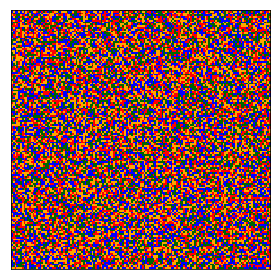

Evaluating on GAN (unif data, 1x sampling).


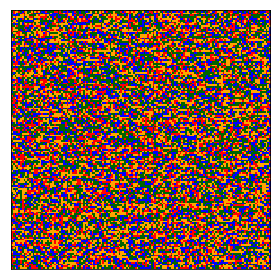

Evaluating on GAN (unif data, 10x sampling).


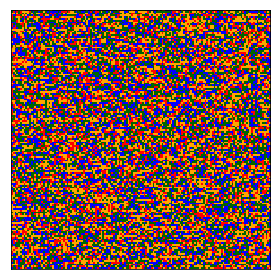

Evaluating on GAN (high-fit data, 1x sampling).


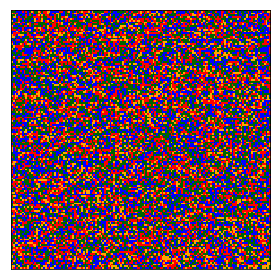

Evaluating on GAN (high-fit data, 10x sampling).


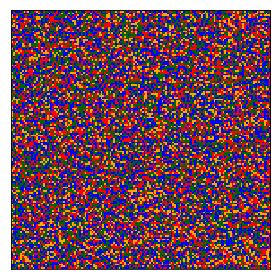

Evaluating on FBGAN (quant = .6, 50 ep).


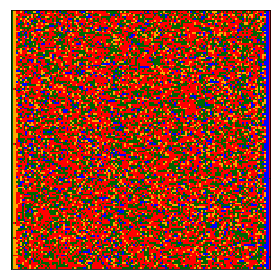

Evaluating on FBGAN (quant = .6, 100 ep).


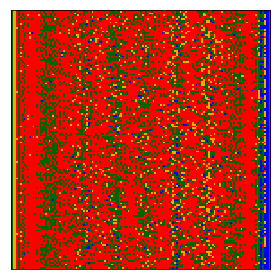

Evaluating on FBGAN (quant = .6, 150 ep).


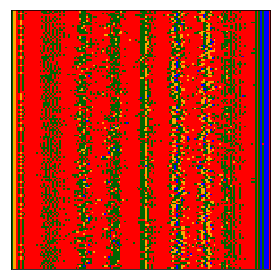

Evaluating on FBGAN (quant = .8, 50 ep).


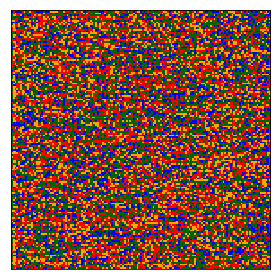

Evaluating on FBGAN (quant = .8, 100 ep).


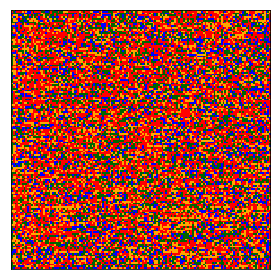

Evaluating on FBGAN (quant = .8, 150 ep).


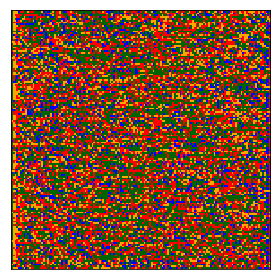

Evaluating on Killoran (1000 iters).


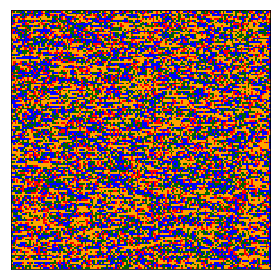

Evaluating on Gradient Ascent (Single PWM).


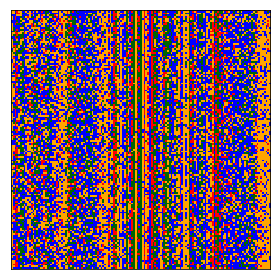

Evaluating on Gradient Ascent (Multi PWM).


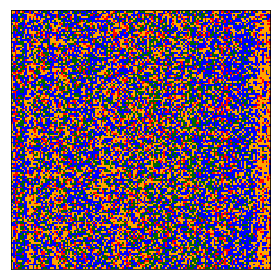

Evaluating on Simulated Annealing (1000 iters).


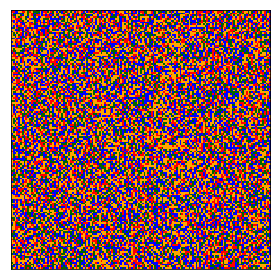

Evaluating on DEN Earthm 3.5 (seq margin 0.5).


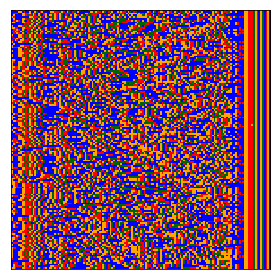

Evaluating on DEN Earthm 3.5 (seq margin 0.3).


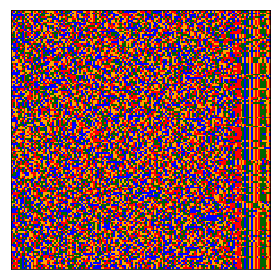

Evaluating on DEN Earthm 4.5 (seq margin 0.5, weight 0.5).


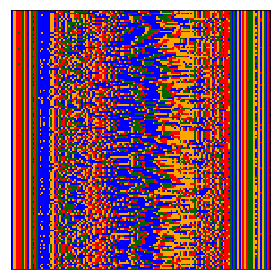

Evaluating on DEN Earthm 4.5 (seq margin 0.3, weight 0.5).


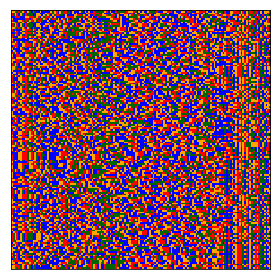

In [10]:
save_figs = True

experiment_suffix = "_den_comparisons"

model_ixs = np.arange(len(model_names)).tolist()#[12, 13, 15, 17]

for temp_ix in model_ixs :

    model_name = model_names[temp_ix]
    model_seqs = model_sequences[temp_ix]
    
    print("Evaluating on " + model_name + ".")

    plot_n_seqs = 145
    plot_start = 0
    plot_end = 145

    flat_pwms = np.zeros((plot_n_seqs, plot_end - plot_start))
    for i in range(plot_n_seqs) :
        for j in range(0, flat_pwms.shape[1]) :
            max_nt_ix = 0
            if model_seqs[i][j + plot_start] == 'A' :
                max_nt_ix = 0
            elif model_seqs[i][j + plot_start] == 'C' :
                max_nt_ix = 1
            elif model_seqs[i][j + plot_start] == 'G' :
                max_nt_ix = 2
            elif model_seqs[i][j + plot_start] == 'T' :
                max_nt_ix = 3

            flat_pwms[i, j] = max_nt_ix + 1

    cmap = colors.ListedColormap(['red', 'blue', 'orange', 'darkgreen'])
    bounds=[0, 1, 2, 3, 4, 5]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    f = plt.figure(figsize=(4, 12))

    plt.imshow(flat_pwms, aspect='equal', interpolation='nearest', origin='lower', cmap=cmap, norm=norm)

    plt.xticks([], [])
    plt.yticks([], [])

    plt.tight_layout()

    if save_figs :
        plt.savefig(problem_prefix + experiment_suffix + "_model_" + str(temp_ix) + "_diversity_seqs.png", transparent=True, dpi=150)
        plt.savefig(problem_prefix + experiment_suffix + "_model_" + str(temp_ix) + "_diversity_seqs.svg")
        plt.savefig(problem_prefix + experiment_suffix + "_model_" + str(temp_ix) + "_diversity_seqs.eps")

    plt.show()

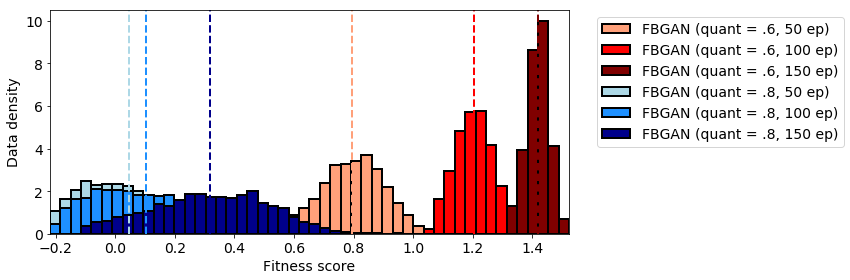

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


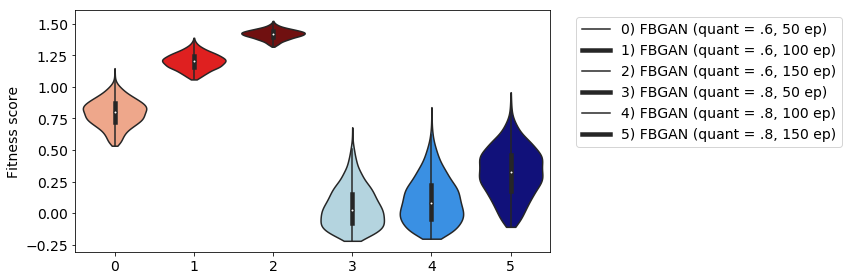

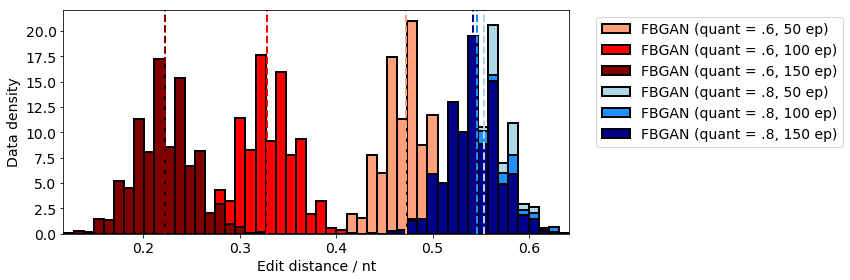

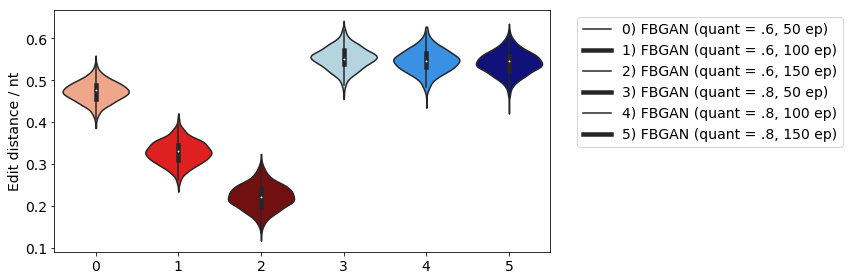

In [11]:
#FBGAN analysis and comparisons

experiment_suffix = "_fbgan_comparisons"

start_ix = 4 + 1
end_ix = 10 + 1

model_colors = ['lightsalmon', 'red', 'maroon', 'lightblue', 'dodgerblue', 'darkblue']

violin_bw = 0.25#None
violin_cut = 0.0

plot_joint_histo(
    fitness_scores[start_ix: end_ix],
    model_names[start_ix: end_ix],
    'Fitness score',
    'Data density',
    colors=model_colors,
    #min_val=-95,
    #max_val=-70,
    #max_y_val = 0.35,
    n_bins=50,
    figsize=(12, 4),
    save_fig=True,
    fig_name=problem_prefix + experiment_suffix + "_fitness_log_histo",
    legend_outside=True
)
plot_joint_cmp(
    fitness_scores[start_ix: end_ix],
    model_names[start_ix: end_ix],
    'Fitness score',
    plot_type='violin',
    colors=model_colors,
    #min_y_val=-95,
    #max_y_val = 0.35,
    figsize=(12, 4),
    save_fig=True,
    fig_name=problem_prefix + experiment_suffix + "_fitness_log_violin",
    legend_outside=True,
    violin_bw=violin_bw,
    violin_cut=violin_cut
)

plot_joint_histo(
    edit_distances[start_ix: end_ix],
    model_names[start_ix: end_ix],
    'Edit distance / nt',
    'Data density',
    colors=model_colors,
    #min_val=-95,
    #max_val=-70,
    #max_y_val = 0.35,
    n_bins=50,
    figsize=(12, 4),
    save_fig=True,
    fig_name=problem_prefix + experiment_suffix + "_edit_distance_histo",
    legend_outside=True
)
plot_joint_cmp(
    edit_distances[start_ix: end_ix],
    model_names[start_ix: end_ix],
    'Edit distance / nt',
    plot_type='violin',
    colors=model_colors,
    #min_y_val=-95,
    #max_y_val = 0.35,
    figsize=(12, 4),
    save_fig=True,
    fig_name=problem_prefix + experiment_suffix + "_edit_distance_violin",
    legend_outside=True,
    violin_bw=violin_bw,
    violin_cut=violin_cut
)


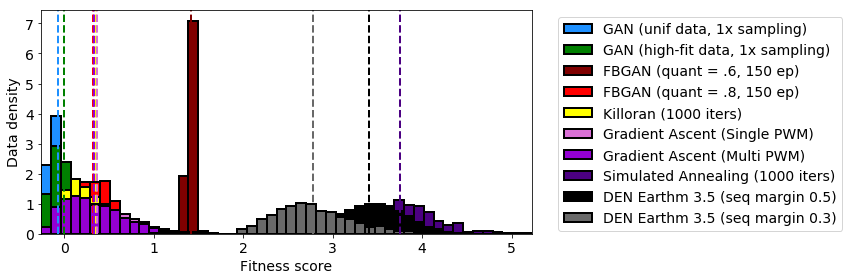

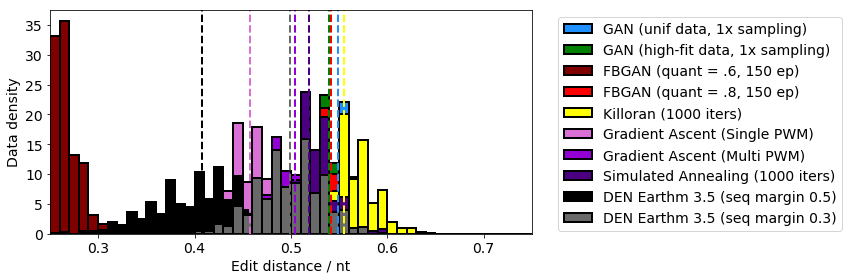

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


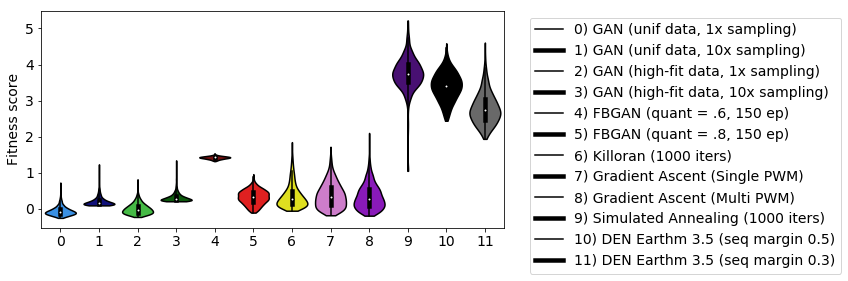

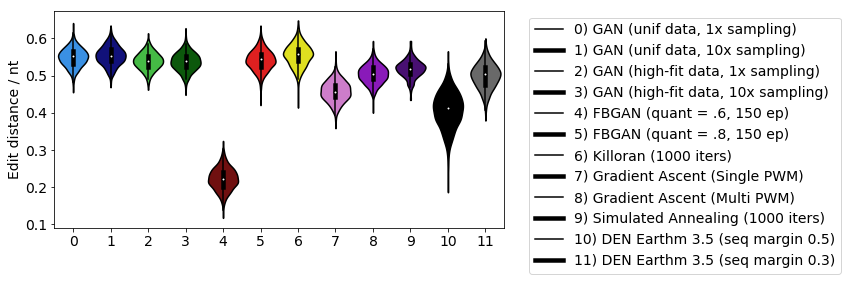

In [10]:
#All models, analysis and comparisons

experiment_suffix = "_all_comparisons"

model_ixs = [1, 3, 7, 10, 11, 12, 13, 14, 15, 16]

model_colors = ['dodgerblue', 'green', 'maroon', 'red', 'yellow', 'orchid', 'darkviolet', 'indigo', 'black', 'dimgrey', 'silver']

violin_bw = 0.25#None
violin_cut = 0.0

plot_joint_histo(
    subselect_list(fitness_scores, model_ixs),
    subselect_list(model_names, model_ixs),
    'Fitness score',
    'Data density',
    colors=model_colors,
    #min_val=-95,
    #max_val=-70,
    #max_y_val = 0.35,
    n_bins=50,
    figsize=(12, 4),
    save_fig=True,
    fig_name=problem_prefix + experiment_suffix + "_fitness_log_histo",
    legend_outside=True
)
plot_joint_histo(
    subselect_list(edit_distances, model_ixs),
    subselect_list(model_names, model_ixs),
    'Edit distance / nt',
    'Data density',
    colors=model_colors,
    min_val=0.25,
    max_val=0.75,
    #max_y_val = 0.35,
    n_bins=50,
    figsize=(12, 4),
    save_fig=True,
    fig_name=problem_prefix + experiment_suffix + "_edit_distance_histo",
    legend_outside=True
)

model_ixs = [1, 2, 3, 4, 7, 10, 11, 12, 13, 14, 15, 16]

model_colors = ['dodgerblue', 'darkblue', 'limegreen', 'darkgreen', 'maroon', 'red', 'yellow', 'orchid', 'darkviolet', 'indigo', 'black', 'dimgrey', 'silver']

plot_joint_cmp(
    subselect_list(fitness_scores, model_ixs),
    subselect_list(model_names, model_ixs),
    'Fitness score',
    plot_type='violin',
    colors=model_colors,
    #min_y_val=-95,
    #max_y_val = 0.35,
    figsize=(12, 4),
    save_fig=True,
    fig_name=problem_prefix + experiment_suffix + "_fitness_log_violin",
    legend_outside=True,
    violin_bw=violin_bw,
    violin_cut=violin_cut
)
plot_joint_cmp(
    subselect_list(edit_distances, model_ixs),
    subselect_list(model_names, model_ixs),
    'Edit distance / nt',
    plot_type='violin',
    colors=model_colors,
    #min_y_val=-95,
    #max_y_val = 0.35,
    figsize=(12, 4),
    save_fig=True,
    fig_name=problem_prefix + experiment_suffix + "_edit_distance_violin",
    legend_outside=True,
    violin_bw=violin_bw,
    violin_cut=violin_cut
)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


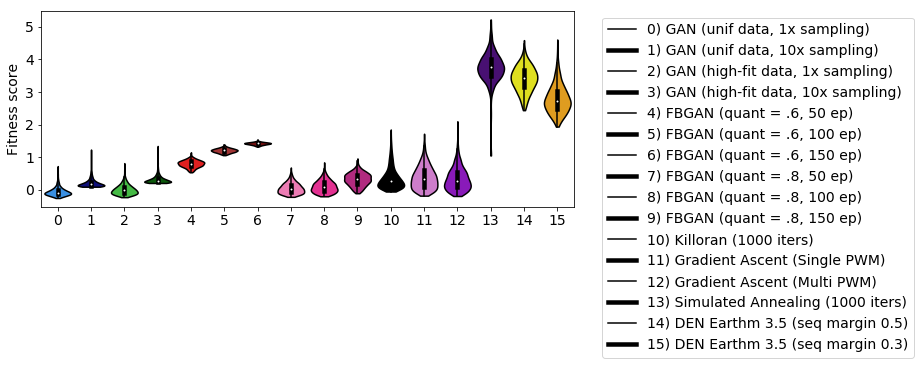

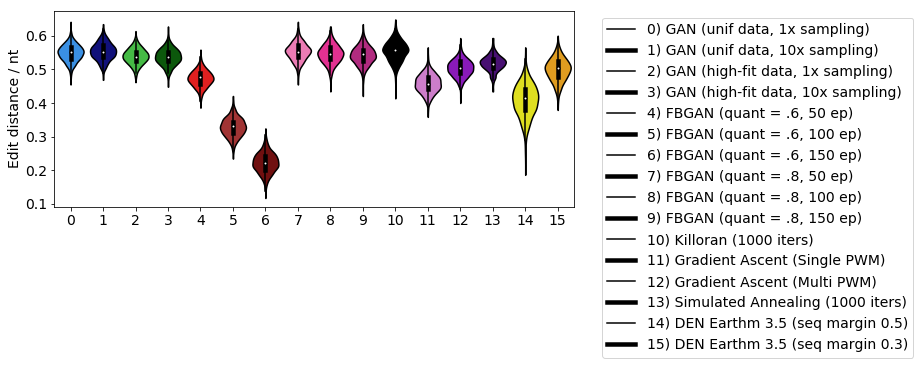

In [12]:
#All models, analysis and comparisons

experiment_suffix = "_all_comparisons_extra"

model_ixs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

model_colors = ['dodgerblue', 'darkblue', 'limegreen', 'darkgreen', 'red', 'firebrick', 'maroon', 'hotpink', 'deeppink', 'mediumvioletred', 'black', 'orchid', 'darkviolet', 'indigo', 'yellow', 'orange']

violin_bw = 0.25
violin_cut = 0.0

plot_joint_cmp(
    subselect_list(fitness_scores, model_ixs),
    subselect_list(model_names, model_ixs),
    'Fitness score',
    plot_type='violin',
    colors=model_colors,
    #min_y_val=-95,
    #max_y_val = 0.35,
    figsize=(13, 4.5),
    save_fig=True,
    fig_name=problem_prefix + experiment_suffix + "_fitness_log_violin",
    legend_outside=True,
    violin_bw=violin_bw,
    violin_cut=violin_cut
)
plot_joint_cmp(
    subselect_list(edit_distances, model_ixs),
    subselect_list(model_names, model_ixs),
    'Edit distance / nt',
    plot_type='violin',
    colors=model_colors,
    #min_y_val=-95,
    #max_y_val = 0.35,
    figsize=(13, 4.5),
    save_fig=True,
    fig_name=problem_prefix + experiment_suffix + "_edit_distance_violin",
    legend_outside=True,
    violin_bw=violin_bw,
    violin_cut=violin_cut
)


In [8]:
#Trajectory comparison configuration

traj_dirs = [
    "../../../fbgan/samples/fbgan_mpradragonn_sample_quantile_cutoff_60/",
    "../../../fbgan/samples/fbgan_mpradragonn_sample_quantile_cutoff_80/",
    
    "../../../fbgan/samples/killoran_mpradragonn/",
    
    "../../../seqprop/examples/mpradragonn/samples/seqprop_mpradragonn_max_activity_single_pwm_50000_updates/",
    "../../../seqprop/examples/mpradragonn/samples/seqprop_mpradragonn_max_activity_multi_pwm_25000_updates/",
    
    "samples/basinhopping_mpradragonn_max_activity_512_sequences_1000_iters/",
    
    "samples/genesis_mpradragonn_max_activity_sv40_25000_updates_similarity_margin_05_earthmover_weight_01_target_35/",
    "samples/genesis_mpradragonn_max_activity_sv40_25000_updates_similarity_margin_03_earthmover_weight_01_target_35/"
]

traj_file_funcs = [
    lambda i: "sampled_" + str((i+1)) + "_preds.txt",
    lambda i: "sampled_" + str((i+1)) + "_preds.txt",
    
    lambda i: "killoran_mpradragonn_960_sequences_1000_iters_sample_wgan_curr_iter_" + str(i * 100) + ".txt",
    
    lambda i: "intermediate_epoch_" + str(i) + "_1_steps.txt",
    lambda i: "intermediate_epoch_" + str(i) + "_1_steps.txt",
    
    lambda i: "intermediate_iter_" + str((i+1) * 100) + ".txt",
    
    lambda i: "intermediate_epoch_" + str(i) + "_960_sequences.txt",
    lambda i: "intermediate_epoch_" + str(i) + "_960_sequences.txt"
]

traj_scale_generator_touch_funcs = [
    lambda i: i * 30 * 10 * 64 + 4096,
    lambda i: i * 30 * 10 * 64 + 4096,
    
    lambda i: i * 100 * 4096,
    
    lambda i: i * 250 + 4096,
    lambda i: i * 250 * 4096,
    
    lambda i: (i+1) * 100 * 4096,
    
    lambda i: (i+1) * 100 * 64 * 10 + 4096,
    lambda i: (i+1) * 100 * 64 * 10 + 4096
]

traj_names = [
    "FBGAN (quant = 0.6)",
    "FBGAN (quant = 0.8)",
    
    "Killoran (1000 iters)",
    
    "Gradient Ascent (Single PWM)",
    "Gradient Ascent (Multi PWM)",
    "Simulated Annealing (1000 iters)",
    
    "DEN (seq margin 0.5)",
    "DEN (seq margin 0.3)"
]

file_indexes = [
    [0, 1, 2, 3, 4, 5, 6, 7, 8] + ((np.arange(25) + 1) * 10 - 1).tolist(),
    [0, 1, 2, 3, 4, 5, 6, 7, 8] + ((np.arange(25) + 1) * 10 - 1).tolist(),
    
    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] + ((np.arange(25) + 1) * 10).tolist(),
    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] + ((np.arange(25) + 1) * 10).tolist(),
    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] + ((np.arange(25) + 1) * 10).tolist(),
    
    [0, 1, 2, 3, 4, 5, 6, 7, 8] + ((np.arange(25) + 1) * 10 - 1).tolist(),
    
    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] + ((np.arange(25) + 1) * 10).tolist(),
    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] + ((np.arange(25) + 1) * 10).tolist()
]


In [9]:
#Load and predict sequence trajectory data

def load_and_aggregate_score(file_path, split_on_tab=True, seq_template=None, predictor=None, batch_size=32, max_n_sequences=960) :
    seqs = []
    
    print("Processing '" + str(file_path) + "'...")
    
    try :
        with open(file_path, "rt") as f :
            for l in f.readlines() :
                l_strip = l.strip()
                seq = l_strip
                if split_on_tab :
                    seq = l_strip.split("\t")[0]

                if seq_template is not None :
                    seq = ''.join([
                        seq_template[j] if seq_template[j] != 'N' else seq[j]
                        for j in range(len(seq))
                    ])

                seqs.append(seq)
        
        if len(seqs) > max_n_sequences :
            seqs = seqs[:max_n_sequences]
        
        def _comp_metrics(_seqs) :
            return compute_metrics(
                _seqs,
                n_seqs_to_test=len(_seqs),
                batch_size=batch_size,
                opt_len=np.sum([1 if seq_template[j] == 'N' else 0 for j in range(len(seq_template))])
            )
        
        score_pred, _, _, z_mean_latent_dists, _, edit_dists = _comp_metrics(seqs)
        
        score_pred_perc_50 = np.percentile(score_pred, 50)
        score_pred_perc_80 = np.percentile(score_pred, 80)
        score_pred_perc_95 = np.percentile(score_pred, 95)
        score_pred_perc_99 = np.percentile(score_pred, 99)
        
        edit_dist_median = np.percentile(edit_dists, 50)
        
        
        
        edit_dist_median_perc_50 = np.percentile(_comp_metrics(subselect_list(seqs, np.nonzero(score_pred >= score_pred_perc_50)[0].tolist()))[-1], 50)
        edit_dist_median_perc_80 = np.percentile(_comp_metrics(subselect_list(seqs, np.nonzero(score_pred >= score_pred_perc_80)[0].tolist()))[-1], 50)
        edit_dist_median_perc_95 = np.percentile(_comp_metrics(subselect_list(seqs, np.nonzero(score_pred >= score_pred_perc_95)[0].tolist()))[-1], 50)
        edit_dist_median_perc_99 = np.percentile(_comp_metrics(subselect_list(seqs, np.nonzero(score_pred >= score_pred_perc_99)[0].tolist()))[-1], 50)
        
        return score_pred_perc_50, score_pred_perc_80, score_pred_perc_95, score_pred_perc_99, edit_dist_median, edit_dist_median_perc_50, edit_dist_median_perc_80, edit_dist_median_perc_95, edit_dist_median_perc_99, score_pred
    
    except FileNotFoundError :
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.zeros(max_n_sequences)


traj_ys = [
    [
        load_and_aggregate_score(
            traj_dirs[model_i] + traj_file_funcs[model_i](file_i),
            seq_template=sequence_template,
            predictor=saved_predictor,
            batch_size=32,
            max_n_sequences=512 if model_i == 5 else 960
        )
        for file_i in file_indexes[model_i]
    ]
    for model_i in range(len(traj_dirs))
]

traj_gen_xs = [
    [
        traj_scale_generator_touch_funcs[model_i](file_i)
        for file_i in file_indexes[model_i]
    ]
    for model_i in range(len(traj_dirs))
]


Processing '../../../fbgan/samples/fbgan_mpradragonn_sample_quantile_cutoff_60/sampled_1_preds.txt'...
Processing '../../../fbgan/samples/fbgan_mpradragonn_sample_quantile_cutoff_60/sampled_2_preds.txt'...
Processing '../../../fbgan/samples/fbgan_mpradragonn_sample_quantile_cutoff_60/sampled_3_preds.txt'...
Processing '../../../fbgan/samples/fbgan_mpradragonn_sample_quantile_cutoff_60/sampled_4_preds.txt'...
Processing '../../../fbgan/samples/fbgan_mpradragonn_sample_quantile_cutoff_60/sampled_5_preds.txt'...
Processing '../../../fbgan/samples/fbgan_mpradragonn_sample_quantile_cutoff_60/sampled_6_preds.txt'...
Processing '../../../fbgan/samples/fbgan_mpradragonn_sample_quantile_cutoff_60/sampled_7_preds.txt'...
Processing '../../../fbgan/samples/fbgan_mpradragonn_sample_quantile_cutoff_60/sampled_8_preds.txt'...
Processing '../../../fbgan/samples/fbgan_mpradragonn_sample_quantile_cutoff_60/sampled_9_preds.txt'...
Processing '../../../fbgan/samples/fbgan_mpradragonn_sample_quantile_cuto

Processing '../../../fbgan/samples/killoran_mpradragonn/killoran_mpradragonn_960_sequences_1000_iters_sample_wgan_curr_iter_900.txt'...
Processing '../../../fbgan/samples/killoran_mpradragonn/killoran_mpradragonn_960_sequences_1000_iters_sample_wgan_curr_iter_1000.txt'...
Processing '../../../fbgan/samples/killoran_mpradragonn/killoran_mpradragonn_960_sequences_1000_iters_sample_wgan_curr_iter_2000.txt'...
Processing '../../../fbgan/samples/killoran_mpradragonn/killoran_mpradragonn_960_sequences_1000_iters_sample_wgan_curr_iter_3000.txt'...
Processing '../../../fbgan/samples/killoran_mpradragonn/killoran_mpradragonn_960_sequences_1000_iters_sample_wgan_curr_iter_4000.txt'...
Processing '../../../fbgan/samples/killoran_mpradragonn/killoran_mpradragonn_960_sequences_1000_iters_sample_wgan_curr_iter_5000.txt'...
Processing '../../../fbgan/samples/killoran_mpradragonn/killoran_mpradragonn_960_sequences_1000_iters_sample_wgan_curr_iter_6000.txt'...
Processing '../../../fbgan/samples/killora

Processing '../../../seqprop/examples/mpradragonn/samples/seqprop_mpradragonn_max_activity_multi_pwm_25000_updates/intermediate_epoch_1_1_steps.txt'...
Processing '../../../seqprop/examples/mpradragonn/samples/seqprop_mpradragonn_max_activity_multi_pwm_25000_updates/intermediate_epoch_2_1_steps.txt'...
Processing '../../../seqprop/examples/mpradragonn/samples/seqprop_mpradragonn_max_activity_multi_pwm_25000_updates/intermediate_epoch_3_1_steps.txt'...
Processing '../../../seqprop/examples/mpradragonn/samples/seqprop_mpradragonn_max_activity_multi_pwm_25000_updates/intermediate_epoch_4_1_steps.txt'...
Processing '../../../seqprop/examples/mpradragonn/samples/seqprop_mpradragonn_max_activity_multi_pwm_25000_updates/intermediate_epoch_5_1_steps.txt'...
Processing '../../../seqprop/examples/mpradragonn/samples/seqprop_mpradragonn_max_activity_multi_pwm_25000_updates/intermediate_epoch_6_1_steps.txt'...
Processing '../../../seqprop/examples/mpradragonn/samples/seqprop_mpradragonn_max_activi

Processing 'samples/genesis_mpradragonn_max_activity_sv40_25000_updates_similarity_margin_05_earthmover_weight_01_target_35/intermediate_epoch_1_960_sequences.txt'...
Processing 'samples/genesis_mpradragonn_max_activity_sv40_25000_updates_similarity_margin_05_earthmover_weight_01_target_35/intermediate_epoch_2_960_sequences.txt'...
Processing 'samples/genesis_mpradragonn_max_activity_sv40_25000_updates_similarity_margin_05_earthmover_weight_01_target_35/intermediate_epoch_3_960_sequences.txt'...
Processing 'samples/genesis_mpradragonn_max_activity_sv40_25000_updates_similarity_margin_05_earthmover_weight_01_target_35/intermediate_epoch_4_960_sequences.txt'...
Processing 'samples/genesis_mpradragonn_max_activity_sv40_25000_updates_similarity_margin_05_earthmover_weight_01_target_35/intermediate_epoch_5_960_sequences.txt'...
Processing 'samples/genesis_mpradragonn_max_activity_sv40_25000_updates_similarity_margin_05_earthmover_weight_01_target_35/intermediate_epoch_6_960_sequences.txt'..

Processing 'samples/genesis_mpradragonn_max_activity_sv40_25000_updates_similarity_margin_03_earthmover_weight_01_target_35/intermediate_epoch_60_960_sequences.txt'...
Processing 'samples/genesis_mpradragonn_max_activity_sv40_25000_updates_similarity_margin_03_earthmover_weight_01_target_35/intermediate_epoch_70_960_sequences.txt'...
Processing 'samples/genesis_mpradragonn_max_activity_sv40_25000_updates_similarity_margin_03_earthmover_weight_01_target_35/intermediate_epoch_80_960_sequences.txt'...
Processing 'samples/genesis_mpradragonn_max_activity_sv40_25000_updates_similarity_margin_03_earthmover_weight_01_target_35/intermediate_epoch_90_960_sequences.txt'...
Processing 'samples/genesis_mpradragonn_max_activity_sv40_25000_updates_similarity_margin_03_earthmover_weight_01_target_35/intermediate_epoch_100_960_sequences.txt'...
Processing 'samples/genesis_mpradragonn_max_activity_sv40_25000_updates_similarity_margin_03_earthmover_weight_01_target_35/intermediate_epoch_110_960_sequence

In [10]:
#Clean up trajectories and convert to numpy arrays

traj_raw = []

for model_i in range(len(traj_dirs)) :
    #traj_ys[model_i] = np.array(list(zip(*traj_ys[model_i])))
    traj_ys[model_i] = list(zip(*traj_ys[model_i]))
    traj_raw.append(np.array(traj_ys[model_i][9]))
    traj_ys[model_i] = np.array(traj_ys[model_i][:9])
    
    traj_gen_xs[model_i] = np.array(traj_gen_xs[model_i])
    
    isnan_index = np.nonzero(np.isnan(traj_ys[model_i][0]))[0]
    
    first_isnan_ix = None
    if len(isnan_index) > 0 :
        first_isnan_ix = isnan_index[0]
    
    if first_isnan_ix is not None :
        traj_ys[model_i] = traj_ys[model_i][:, :first_isnan_ix]
        traj_gen_xs[model_i] = traj_gen_xs[model_i][:first_isnan_ix]


In [11]:
#Plot overlapping training trajectories

def plot_trajectories(iterations, measures, model_names, add_zeros, measure_ix, x_label, y_label, colors=None, figsize=(6, 4), legend_outside=False, save_fig=False, fig_name="default_1", fig_dpi=150, min_x_val=0, max_x_val=None, min_y_val=None, max_y_val=None, log10_scale=False) :
    
    f = plt.figure(figsize=figsize)
    
    max_iter_val = 0
    
    ls = []
    for model_ix, [iters, all_meas] in enumerate(zip(iterations, measures)) :
        meas = np.zeros(all_meas[measure_ix, :].shape)
        meas[:] = all_meas[measure_ix, :]
        
        iters_copy = np.zeros(iters.shape)
        iters_copy[:] = iters[:]
        
        if add_zeros[model_ix] is not None :
            iters_copy = np.concatenate([np.array([0]), iters_copy], axis=0)
            meas = np.concatenate([np.array([add_zeros[model_ix]]), meas], axis=0)
        
        if log10_scale :
            iters_copy[1:] = np.log10(iters_copy[1:])
        
        max_iter_val = max(max_iter_val, np.max(iters_copy))
        
        l1 = None
        if colors is not None :
            l1 = plt.plot(iters_copy, meas, color=colors[model_ix], linewidth=2, label=model_names[model_ix])
        else :
            l1 = plt.plot(iters_copy, meas, linewidth=2, label=model_names[model_ix])
        
        ls.append(l1[0])

    if log10_scale :
        plt.xticks(np.arange(int(max_iter_val) + 1), 10**np.arange(int(max_iter_val) + 1), fontsize=14)
    else :
        plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    if max_x_val is not None :
        plt.xlim(min_x_val, max_x_val)
    else :
        plt.xlim(min_x_val, max_iter_val)
    
    if min_y_val is not None and max_y_val is not None :
        plt.ylim(min_y_val, max_y_val)

    plt.xlabel(x_label, fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    
    if not legend_outside :
        plt.legend(handles=ls, fontsize=14, loc='upper left')
    else :
        plt.legend(handles=ls, fontsize=14, bbox_to_anchor=(1.04,1), loc="upper left")
    
    plt.tight_layout()
    
    if save_fig :
        plt.savefig(fig_name + ".eps")
        plt.savefig(fig_name + ".svg")
        plt.savefig(fig_name + ".png", dpi=fig_dpi, transparent=True)
    
    plt.show()

def plot_raw_trajectories(iterations, trajs, model_name, x_label, y_label, plot_n_trajs=100, figsize=(6, 4), legend_outside=False, save_fig=False, fig_name="default_1", fig_dpi=150, max_x_val=None, min_y_val=None, max_y_val=None) :
    
    f = plt.figure(figsize=figsize)
    
    for traj_ix in range(min(trajs.shape[1], plot_n_trajs)) :
        plt.plot(iterations, trajs[:, traj_ix][:iterations.shape[0]], linewidth=2)

    plt.xticks(fontsize=14, rotation=45)
    plt.yticks(fontsize=14)
    
    if max_x_val is not None :
        plt.xlim(0, max_x_val)
    else :
        plt.xlim(0, np.max(iterations))
    
    if min_y_val is not None and max_y_val is not None :
        plt.ylim(min_y_val, max_y_val)

    plt.xlabel(x_label, fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    plt.title(model_name, fontsize=14)
    
    plt.tight_layout()
    
    if save_fig :
        plt.savefig(fig_name + ".eps")
        plt.savefig(fig_name + ".svg")
        plt.savefig(fig_name + ".png", dpi=fig_dpi, transparent=True)
    
    plt.show()


_50th_perc


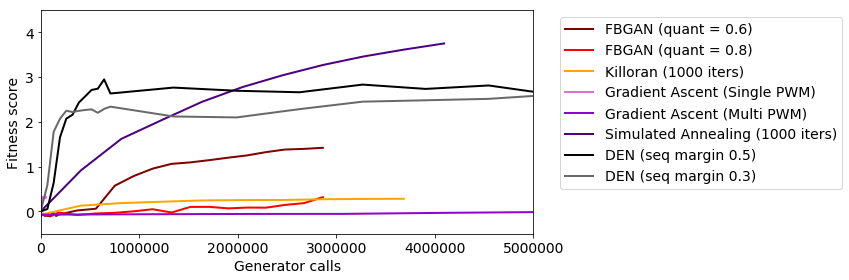

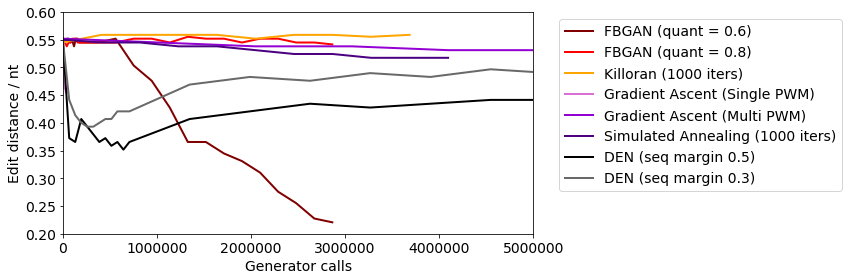

_80th_perc


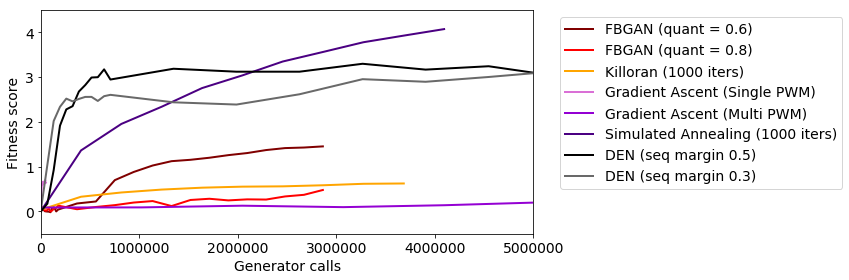

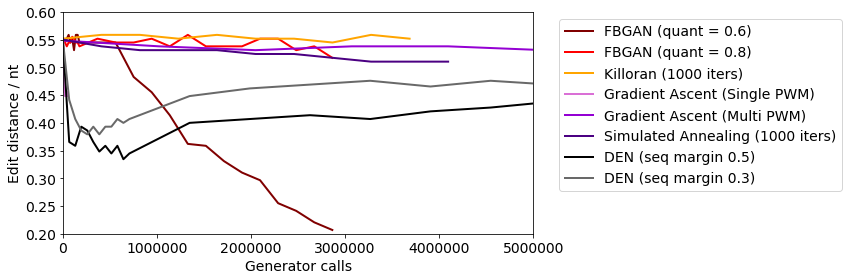

_95th_perc


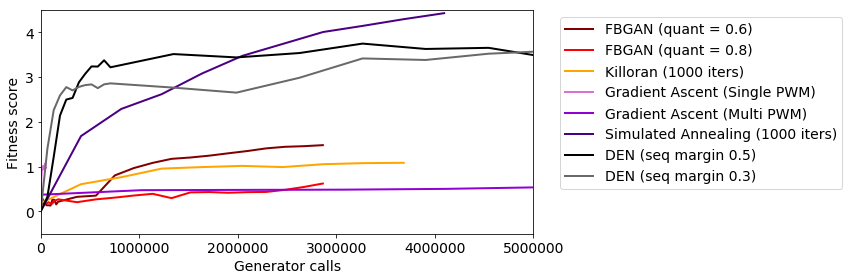

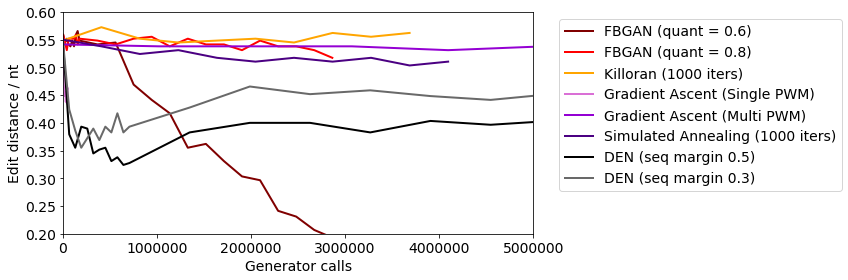

_99th_perc


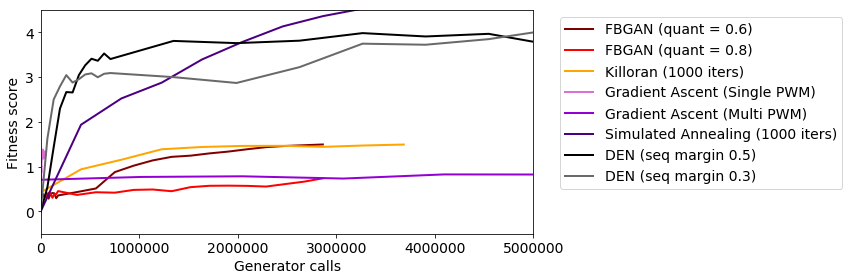

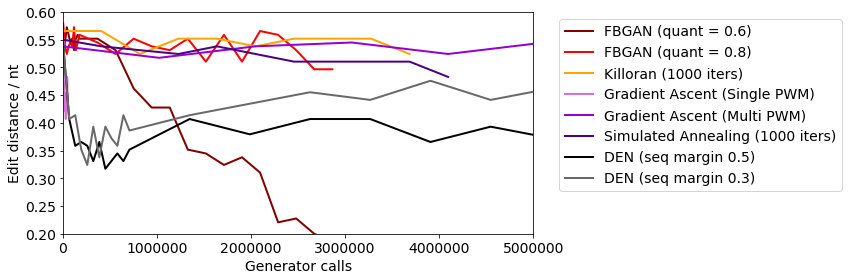

In [12]:
#Plot trajectory data

experiment_suffix = "_traj_comparisons_st_samples"

model_colors = ['maroon', 'red', 'orange', 'orchid', 'darkviolet', 'indigo', 'black', 'dimgrey', 'grey']

figsize = (12, 4)

#Generator time scale

for perc_ix, perc_suffix in enumerate(['_50th_perc', '_80th_perc', '_95th_perc', '_99th_perc']) :

    print(perc_suffix)
    
    plot_trajectories(
        traj_gen_xs,
        traj_ys,
        traj_names,
        [None, None, None, None, None, 0, 0, 0],
        perc_ix,
        'Generator calls',
        'Fitness score',
        colors=model_colors,
        min_x_val=4096,
        max_x_val=5000000,
        min_y_val=-0.5,
        max_y_val=4.5,
        figsize=figsize,
        save_fig=True,
        fig_name=problem_prefix + experiment_suffix + "_fitness_log" + perc_suffix,
        legend_outside=True,
        log10_scale=False
    )

    plot_trajectories(
        traj_gen_xs,
        traj_ys,
        traj_names,
        [None, None, None, None, None, 0.55, 0.55, 0.55, 0.55],
        4 if perc_ix == 0 else 4 + (perc_ix + 1),
        'Generator calls',
        'Edit distance / nt',
        colors=model_colors,
        min_x_val=4096,
        max_x_val=5000000,
        min_y_val=0.2,
        max_y_val=0.6,
        figsize=figsize,
        save_fig=True,
        fig_name=problem_prefix + experiment_suffix + "_edit_distance" + perc_suffix,
        legend_outside=True,
        log10_scale=False
    )


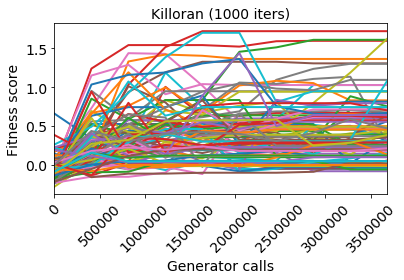

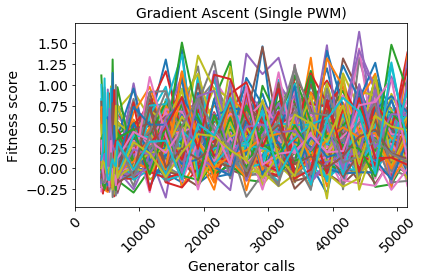

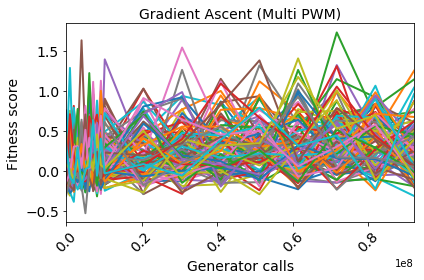

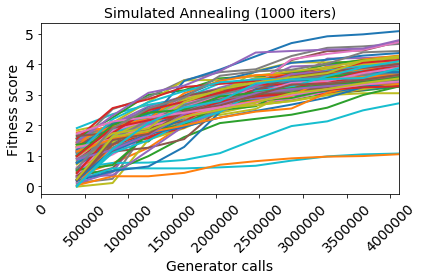

In [14]:

for model_ix in [2, 3, 4, 5] :
    
    plot_raw_trajectories(
        traj_gen_xs[model_ix],
        traj_raw[model_ix],
        traj_names[model_ix],
        'Generator calls',
        'Fitness score',
        plot_n_trajs=100,
        max_x_val=None,
        min_y_val=None,
        max_y_val=None,
        figsize=(6, 4),
        legend_outside=False,
        save_fig=True,
        fig_name=problem_prefix + experiment_suffix + "_raw_trajs_model_" + str(model_ix)
    )
